# Sentiment Analysis of Yelp Reviews - Modeling

#### Prepared By: Ben Chamblee - https://github.com/Bench-amblee

## Contents

* [Introduction](#Introduction)          


* [Part 1: Machine Learning with Extracted Features](#Part1)
    * [Logistic Regression](#Logistic_Regression)
    * [Random Forest](#Random_Forest)
    * [Support Vector Classification](#SVC)
    * [Gradient Boosted Classification](#GBC)
    * [Results](#Results1)   
    

* [Part 2: Machine Learning with Bag of Words](#Part2)
    * [Naive Bayes with CountVectorizer](#NB_CV)
    * [Naive Bayes with TFIDF](#NB_TF)
    * [Gradient Boosted Classification with Count Vectorizer](#GBC_CV)
    * [Gradient Boosted Classification with TFIDF](#GBC_TF)
    * [Results](#Results2)      
    

* [Part 3: Embedding Techniques](#Part3)
    * [Dense + Sparse Features](#Dense)
    * [Naive Bayes Probability with Dense + Sparse Features](#NB_Sparse)
    * [Stacked Model](#Stacked)
    * [Results](#Results3)       
    
    
* [Conclusion](#Conclusion)

## Introduction

We've collected the data, analyzed it, found the most important feautres, and have a baseline accuracy around 70%. Now we'll be going through some other methods of modeling to find the most accurate version so we can deploy it for future yelp review classifications

In this notebook we will:
- Test out multiple different models
- Including Regular ML Models with our extracted features and embedded models with sparse/dense text matrices

## Imports

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

yelp_data = pd.read_csv('yelp_data_sentiment.csv')

In [2]:
yelp_data.head()

,Name,Review,Polarity,Sentiment,Positive_Words_P,chocol,cup,amaz,eat,year,...,linguin,linguini,jimmi,player,juliana,pool tabl,castl,falafel,paella,white castl
0,Morris Park Bake Shop,'The chocolate cups are amazing! Have been eat...,0.500000,Positive,0.222222,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
1,Morris Park Bake Shop,'Morris Park Bake Shop has become my go to spo...,0.338889,Slightly Positive,0.206897,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
2,Morris Park Bake Shop,'I thought the cookies and biscotti were prett...,0.314583,Slightly Positive,0.130435,0.0,0.0,0.0,0.0,0.160339,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0
3,Morris Park Bake Shop,'Guys.... so Im a big time biscotti connoisseu...,0.238068,Slightly Positive,0.127660,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.149255,0.0,0.0,0.0
4,Morris Park Bake Shop,'I had a craving for a special type of cake wi...,0.314643,Slightly Positive,0.218750,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0


## Part 1: Machine Learning with Extracted Features<a id='Part1'></a>

There are many different models we can try but to start we're going to work with the standard machine learning models like logistic regression and random forest

I'll be collecting accuracy and f1 scores along the way to see which model performs the best with this data!

Here's what the process will look like:

- Choose a model type
- Define a pipeline and use GridSearch to find the best parameters
- Save the model so we don't have the run the cell multiple times
- Load the model and run accuracy and f1 scores
- Move on to the next model

In [3]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, accuracy_score, f1_score
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import pickle
from pycm import *

X = yelp_data.iloc[0:,4:]
y = yelp_data.Sentiment
indices = yelp_data.index

X_train, X_test, y_train, y_test, itrain, itest = train_test_split(X,y,indices,train_size=0.8,random_state=7)

### Logistic Regression<a id='Logistic_Regression'></a>

For this model we're going to create a pipeline that uses the standard scaler and a classifier using GridSearch to find the best parameters

In [4]:
steps = [('scaler', StandardScaler()), ('lr', LogisticRegression(solver = 'lbfgs'))] 
pipeline = Pipeline(steps)
parameters = {'lr__C':[0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
clf.fit(X_train, y_train)
clf.best_params_

{'lr__C': 0.1}

In [5]:
filename = 'lr.sav'
pickle.dump(clf, open(filename, 'wb'))

In [10]:
filename = 'lr.sav'
clf = pickle.load(open(filename, 'rb'))

In [11]:
results = clf.predict(X_test)

In [12]:
test_accuracy = clf.score(X_test, y_test)
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.6951553930530164
F1 Score (macro):  0.6933462169665948
F1 Score (micro):  0.6951553930530164
F1 Score (weighted):  0.6957884475947633


In [13]:
lr_acc = test_accuracy
lr_f1 = f1_accuracy
lr_f1m = f1_accuracym
lr_f1w = f1_accuracyw

### Random Forest<a id='Random_Forest'></a>

Same thing here, first we'll make a pipeline and then use gridsearch to find the best parameters to tune this model

In [10]:
from sklearn.ensemble import RandomForestClassifier

In [11]:
steps = [('scaler', StandardScaler()), ('rf', RandomForestClassifier())] 
pipeline = Pipeline(steps) 
parameters = {'rf__n_estimators':[10 , 20, 30, 40, 50], 'rf__max_features':['auto','sqrt']}
clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'rf__max_features': 'sqrt', 'rf__n_estimators': 50}

In [12]:
filename = 'rf.sav'
pickle.dump(clf, open(filename, 'wb'))

In [14]:
filename = 'rf.sav'
clf = pickle.load(open(filename, 'rb'))

In [15]:
results = clf.predict(X_test)

In [16]:
test_accuracy = clf.score(X_test, y_test)
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.6604204753199269
F1 Score (macro):  0.6617321163064211
F1 Score (micro):  0.6604204753199269
F1 Score (weighted):  0.6601505940738249


In [17]:
rf_acc = test_accuracy
rf_f1 = f1_accuracy
rf_f1m = f1_accuracym
rf_f1w = f1_accuracyw

### Support Vector Classification (SVC)<a id='SVC'></a>

For the SVC model I will unfortunately have to set the kernel to 'linear' and the gamma to 'auto' just because my laptop doesn't have sufficient computing power to train the model in a reasonable amount of time. This may not give us a perfect result, but we will still see the benefits of an SVC model

In [25]:
from sklearn.svm import SVC

steps = [('scaler', StandardScaler()), ('svc', SVC(probability=False,kernel='linear',gamma='auto'))] 
pipeline = Pipeline(steps) 
parameters = {'svc__C':[0.01, 0.1, 1]}

clf = GridSearchCV(pipeline, parameters, cv = 3, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'svc__C': 0.01}

In [28]:
filename = 'svc.sav'
pickle.dump(clf, open(filename, 'wb'))

In [29]:
filename = 'svc.sav'
clf = pickle.load(open(filename, 'rb'))

In [30]:
results = clf.predict(X_test)

In [31]:
test_accuracy = clf.score(X_test, y_test)
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.7010968921389397
F1 Score (macro):  0.7017782289569849
F1 Score (micro):  0.7010968921389397
F1 Score (weighted):  0.701150485468546


In [32]:
svc_acc = test_accuracy
svc_f1 = f1_accuracy
svc_f1m = f1_accuracym
svc_f1w = f1_accuracyw

### Gradient Boosted Classifier<a id='GBC'></a>

In [33]:
from sklearn.ensemble import GradientBoostingClassifier

steps = [('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier(max_features='sqrt'))] 
pipeline = Pipeline(steps) 
parameters = {'gbc__n_estimators':[10, 50, 100, 200, 500], 'gbc__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25]}

clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'gbc__learning_rate': 0.15, 'gbc__n_estimators': 500}

In [34]:
steps = [('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier(learning_rate = 0.15, max_features = 'sqrt', n_estimators = 500))] 
clf = Pipeline(steps) 
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gbc',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.15, loss='deviance',
                                            max_depth=3, max_features='sqrt',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=500,
                                            n_iter_no_change=None,
               

In [35]:
filename = 'gbc.sav'
pickle.dump(clf, open(filename, 'wb'))

In [36]:
filename = 'gbc.sav'
clf = pickle.load(open(filename, 'rb'))

In [37]:
results = clf.predict(X_test)

In [38]:
test_accuracy = clf.score(X_test, y_test)
probs = clf.predict_proba(X_test)[:, 1]
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.706581352833638
F1 Score (macro):  0.7078660118314662
F1 Score (micro):  0.706581352833638
F1 Score (weighted):  0.7070986252081772


In [39]:
gbc_acc = test_accuracy
gbc_f1 = f1_accuracy
gbc_f1m = f1_accuracym
gbc_f1w = f1_accuracyw

### Results<a id='Results1'></a>

Now we have all our scores, let's see which model performed the best

In [91]:
result1 = pd.DataFrame({'Model':['Logistic Regression', 'Random Forest', 'SVC', 'GBC'],
             'Accuracy':[lr_acc, rf_acc, svc_acc, gbc_acc],
             'F1_Macro':[lr_f1, rf_f1, svc_f1, gbc_f1],
             'F1_Micro':[lr_f1m, rf_f1m, svc_f1m, gbc_f1m],
             'F1_Weighted':[lr_f1w, rf_f1w, svc_f1w, gbc_f1w]})
result1 = result1.round(3)
result1

,Model,Accuracy,F1_Macro,F1_Micro,F1_Weighted
0,Logistic Regression,0.695,0.693,0.695,0.696
1,Random Forest,0.660,0.662,0.660,0.660
2,SVC,0.701,0.702,0.701,0.701
3,GBC,0.707,0.708,0.707,0.707


Looks like the gradient boosted classifier has the highest scores in all categories, we'll be moving on with that one as our top pick

### Confusion Matrix

To get a better idea of how accurate the GBC model is, let's generate a simple confusion matrix

In [43]:
filename = 'gbc.sav'
clf = pickle.load(open(filename, 'rb'))

In [46]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, clf.predict(X_test), labels=None, sample_weight=None)

array([[183,   3, 102,  14],
       [  3, 328,   8, 123],
       [ 28,   8, 403, 155],
       [  2,  78, 118, 632]], dtype=int64)

Slightly more accurate than the logistic regression but there are still some issues when it comes to the slightly negative and slightly positive categories

Let's take a closer look at some of the misclassified instances

In [47]:
my_indices = np.where(y_test != clf.predict(X_test))[0]
misclassified = [itest[i] for i in my_indices]

In [49]:
df_mis = yelp_data[yelp_data.index.isin(misclassified)]
df_mis.head()

,Name,Review,Polarity,Sentiment,Positive_Words_P,chocol,cup,amaz,eat,year,...,linguin,linguini,jimmi,player,juliana,pool tabl,castl,falafel,paella,white castl
5,Morris Park Bake Shop,'Went here yesterday for the Black Forest Cake...,0.377083,Slightly Positive,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
21,Morris Park Bake Shop,'Hey I just heard you bought the Captains. Im ...,0.650000,Positive,0.045455,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
27,Morris Park Bake Shop,"'I like their Pastries. My Mom, Grandma and I ...",0.433333,Positive,0.096774,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
42,Morris Park Bake Shop,"'Sorry, its really not good. Food not really w...",0.337037,Slightly Positive,0.333333,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
46,Morris Park Bake Shop,'Love their bread and pastries. It has a small...,0.190625,Slightly Negative,0.214286,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


It seems like each time there's an issue with Positive Words %, If you look at the five above:
- The first one has a % of a Positive Review but is only Slightly Positive
- The second one has a % of a Negative Review but is assigned Positive
- The third one has a % of a Negative Review but is assigned Positive

and vice versa

We might be putting too much emphasis on the positive words percentage, so let's take a step back and work with pure text data instead to see if they perform better

## Part 2: Machine Learning Models with Bag of Words<a id='Part2'></a>

This time around we'll be working backwards, we've already done feature selection for our text, but with these methods we should be able to construct a dense/sparse text matrix and make an independent prediction based on just the text

This way we won't have any issues with the positive word % having too much weight

The goal here is to find a purely text based model to generate a prediction, then to assign that prediciton to a new feature and add that to a GBC model. This should significantly improve performance

In [50]:
# new pure text based dataset

X = yelp_data.Review
y = yelp_data.Sentiment
indices = yelp_data.index

In [51]:
# same split, size and random state
X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X, y, indices, train_size = 0.8, random_state = 7)

### Naive Bayes with CountVectorizer<a id='NB_CV'></a>

Now we're going to test two classification methods with two different text vectorizers to get the best result, first we'll do Naive Bayes with CV and TFIDF

In [53]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import MultinomialNB

steps = [('vec', CountVectorizer(stop_words = 'english', ngram_range = (1, 2))), ('nb', MultinomialNB())] 
pipeline = Pipeline(steps) 
parameters = {'vec__min_df':[0.01, 0.1, 1, 10, 100], 'nb__alpha':[0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'nb__alpha': 1, 'vec__min_df': 10}

In [54]:
filename = 'nb_cv.sav'
pickle.dump(clf, open(filename, 'wb'))

In [55]:
filename = 'nb_cv.sav'
clf = pickle.load(open(filename, 'rb'))

In [56]:
results = clf.predict(X_test)

In [57]:
test_accuracy = clf.score(X_test, y_test)
probs = clf.predict_proba(X_test)[:, 1]
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.6019195612431444
F1 Score (macro):  0.6083355573090992
F1 Score (micro):  0.6019195612431444
F1 Score (weighted):  0.6012663305321387


In [58]:
nb_cv_acc = test_accuracy
nb_cv_f1 = f1_accuracy
nb_cv_f1m = f1_accuracym
nb_cv_f1w = f1_accuracyw

### Naive Bayes with TFIDF<a id='NB_TF'></a>

In [60]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

steps = [('vec', TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2))), ('nb', MultinomialNB())] 
pipeline = Pipeline(steps) 
parameters = {'vec__min_df':[0.01, 0.1, 1, 10, 100], 'nb__alpha':[0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'nb__alpha': 0.1, 'vec__min_df': 10}

In [61]:
filename = 'nb_tf.sav'
pickle.dump(clf, open(filename, 'wb'))

In [62]:
filename = 'nb_tf.sav'
clf = pickle.load(open(filename, 'rb'))

In [63]:
results = clf.predict(X_test)

In [64]:
test_accuracy = clf.score(X_test, y_test)
probs = clf.predict_proba(X_test)[:, 1]
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.5795246800731262
F1 Score (macro):  0.5673207909897391
F1 Score (micro):  0.5795246800731262
F1 Score (weighted):  0.5734084386831486


In [65]:
nb_tf_acc = test_accuracy
nb_tf_f1 = f1_accuracy
nb_tf_f1m = f1_accuracym
nb_tf_f1w = f1_accuracyw

### Gradient Boosted Classifier with Count Vectorizer<a id='GBC_CV'></a>

Now let's see if GBC works best for text methods as well, it performed very well in the first ML model so let's see if it does well with text, CV, and TFIDF

In [68]:
steps = [('vec', CountVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 2))), 
         ('gbc', GradientBoostingClassifier(max_features='sqrt'))] 
pipeline = Pipeline(steps) 
parameters = {'gbc__n_estimators':[10, 50, 100, 200, 500], 'gbc__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25]}

clf = GridSearchCV(pipeline, parameters, cv = 3, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'gbc__learning_rate': 0.2, 'gbc__n_estimators': 500}

In [77]:
steps = [('vec', CountVectorizer(min_df = 1, stop_words = 'english', ngram_range = (1, 2))), 
         ('gbc', GradientBoostingClassifier(learning_rate = 0.2, max_features = 'sqrt', n_estimators = 500))] 
clf = Pipeline(steps) 
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vec',
                 CountVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.int64'>, encoding='utf-8',
                                 input='content', lowercase=True, max_df=1.0,
                                 max_features=None, min_df=1,
                                 ngram_range=(1, 2), preprocessor=None,
                                 stop_words='english', strip_accents=None,
                                 token_pattern='(?u)\\b\\w\\w+\\b',
                                 tokenizer=None, vocabulary...
                                            learning_rate=0.2, loss='deviance',
                                            max_depth=3, max_features='sqrt',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                          

In [78]:
filename = 'gbc_cv.sav'
pickle.dump(clf, open(filename, 'wb'))

In [79]:
filename = 'gbc_cv.sav'
clf = pickle.load(open(filename, 'rb'))

In [80]:
results = clf.predict(X_test)

In [81]:
test_accuracy = clf.score(X_test, y_test)
probs = clf.predict_proba(X_test)[:, 1]
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.6106032906764168
F1 Score (macro):  0.5994998575972239
F1 Score (micro):  0.6106032906764168
F1 Score (weighted):  0.6059922535714606


In [73]:
gbc_cv_acc = test_accuracy
gbc_cv_f1 = f1_accuracy
gbc_cv_f1m = f1_accuracym
gbc_cv_f1w = f1_accuracyw

### Gradient Boosted Classifier with TFIDF<a id='GBC_TF'></a>

In [74]:
steps = [('vec', TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2))), 
         ('gbc', GradientBoostingClassifier(max_features='sqrt',n_estimators=500))] 
pipeline = Pipeline(steps) 
parameters = {'gbc__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25]}

clf = GridSearchCV(pipeline, parameters, cv = 3, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'gbc__learning_rate': 0.25}

In [82]:
steps = [('vec', TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2))), 
         ('gbc', GradientBoostingClassifier(learning_rate = 0.25, max_features = 'sqrt', n_estimators = 500))] 
clf = Pipeline(steps) 
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('vec',
                 TfidfVectorizer(analyzer='word', binary=False,
                                 decode_error='strict',
                                 dtype=<class 'numpy.float64'>,
                                 encoding='utf-8', input='content',
                                 lowercase=True, max_df=1.0, max_features=None,
                                 min_df=1, ngram_range=(1, 2), norm='l2',
                                 preprocessor=None, smooth_idf=True,
                                 stop_words='english', strip_accents=None,
                                 sublinear_tf=False,
                                 token_patter...
                                            learning_rate=0.25, loss='deviance',
                                            max_depth=3, max_features='sqrt',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
       

In [83]:
filename = 'gbc_tf.sav'
pickle.dump(clf, open(filename, 'wb'))

In [84]:
filename = 'gbc_tf.sav'
clf = pickle.load(open(filename, 'rb'))

In [85]:
results = clf.predict(X_test)

In [86]:
test_accuracy = clf.score(X_test, y_test)
probs = clf.predict_proba(X_test)[:, 1]
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.6288848263254113
F1 Score (macro):  0.6279265160424421
F1 Score (micro):  0.6288848263254113
F1 Score (weighted):  0.6270920571839115


In [87]:
gbc_tf_acc = test_accuracy
gbc_tf_f1 = f1_accuracy
gbc_tf_f1m = f1_accuracym
gbc_tf_f1w = f1_accuracyw

### Results<a id='Results2'></a>

In [94]:
result2 = pd.DataFrame({'Model':['NB_CV', 'NB_TF', 'GBC_CV', 'GBC_TF'],
             'Accuracy':[nb_cv_acc, nb_tf_acc, gbc_cv_acc, gbc_tf_acc],
             'F1_Macro':[nb_cv_f1, nb_tf_f1, gbc_cv_f1, gbc_tf_f1],
             'F1_Micro':[nb_cv_f1m, nb_tf_f1m, gbc_cv_f1m, gbc_tf_f1m],
             'F1_Weighted':[nb_cv_f1w, nb_tf_f1w, gbc_cv_f1w, gbc_tf_f1w]})
result2 = result2.round(3)
result2

,Model,Accuracy,F1_Macro,F1_Micro,F1_Weighted
0,NB_CV,0.602,0.608,0.602,0.601
1,NB_TF,0.580,0.567,0.580,0.573
2,GBC_CV,0.610,0.600,0.610,0.604
3,GBC_TF,0.629,0.628,0.629,0.627


In this case, the Naive Bayes TFIDF is the best choice. The combination of the GBC model and this one should lead to a very strong model

## Part 3: Ensembling Techniques<a id='Part3'></a>

As stated before, this next step is going to combine the results from the best two models above. We'll calculate the sparse/dense matrix of all the review's text and run it through the Naive Bayes TFIDF model to get a probability for each classification group

Once we have that probability we can add it as a feature to the GBC model and have a stacked model which should be much more accurate

### Dense + Sparse Features<a id='Dense'></a>

In [96]:
df_combined = yelp_data
df_combined['text'] = yelp_data['Review']
vec = TfidfVectorizer(stop_words = 'english', ngram_range = (1, 2))
vec_fit = vec.fit(df_combined.text)
sf = vec.fit_transform(df_combined.text)
sf

<10937x348260 sparse matrix of type '<class 'numpy.float64'>'
	with 1009478 stored elements in Compressed Sparse Row format>

In [109]:
from sklearn.preprocessing import MinMaxScaler

dense_feat = df_combined.drop(['Name', 'Review', 'Sentiment','text'],axis=1)

ss = MinMaxScaler()

dense_feat = ss.fit_transform(dense_feat)
dense_feat

array([[0.75      , 0.34920635, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.66944444, 0.32512315, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.65729167, 0.20496894, 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.6875    , 0.3343465 , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.4953125 , 0.15207373, 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.53333333, 0.20952381, 0.        , ..., 0.        , 0.        ,
        0.        ]])

In [110]:
from scipy.sparse import coo_matrix, hstack

dense_feat = coo_matrix(dense_feat)
dense_feat

<10937x1758 sparse matrix of type '<class 'numpy.float64'>'
	with 474230 stored elements in COOrdinate format>

474,000 is a lot, but it's much less than 1,000,000

In [112]:
# new training data with the same text but in dense matrix format

X = hstack([sf, dense_feat.astype(float)])
y = yelp_data.Sentiment
indices = yelp_data.index

In [113]:
# same size, random state

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X, y, indices, train_size = 0.8, random_state = 7)

In [114]:
X_train

<8749x350018 sparse matrix of type '<class 'numpy.float64'>'
	with 1194914 stored elements in Compressed Sparse Row format>

### Naive Bayes Probability with dense + sparse features<a id='NB_Sparse'></a>

Now that we've got our dense matrix training set, let's train a NB model with the data so we can calculate the probability feature

In [116]:
steps = [('nb', MultinomialNB())] 
pipeline = Pipeline(steps) 
parameters = {'nb__alpha':[0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'nb__alpha': 0.01}

In [176]:
filename = 'stacked_nb_ds.sav'
pickle.dump(clf, open(filename, 'wb'))

In [177]:
filename = 'stacked_nb_ds.sav'
clf = pickle.load(open(filename, 'rb'))

In [178]:
results = clf.predict(X_test)

In [179]:
test_accuracy = clf.score(X_test, y_test)
probs = clf.predict_proba(X_test)[:, 1]
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.7116087751371115
F1 Score (macro):  0.7137919724810198
F1 Score (micro):  0.7116087751371115
F1 Score (weighted):  0.7121127612548901


In [161]:
stacked_nb_ds_acc = test_accuracy
stacked_nb_ds_f1 = f1_accuracy
stacked_nb_ds_f1m = f1_accuracym
stacked_nb_ds_f1w = f1_accuracyw

### Stacked Model (dense and sparse features + numerical features)<a id='Stacked'></a>

First step is to make a new test train split that is just text based, then we can compute the probability that the text is in one of four categories using the dense NB model above

In [124]:
X = yelp_data.Review
y = yelp_data.Sentiment
indices = yelp_data.index

X_train, X_test, y_train, y_test, i_train, i_test = train_test_split(X, y, indices, train_size = 0.8, random_state = 7)

In [126]:
steps = [('vec', CountVectorizer(stop_words = 'english', ngram_range = (1, 2))),
         ('nb', MultinomialNB())]
pipeline = Pipeline(steps)
parameters = {'vec__min_df':[0.01, 0.1, 1, 10, 100],
              'nb__alpha':[0.01, 0.1, 1, 10, 100]}

clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy")
clf.fit(X_train, y_train)

GridSearchCV(cv=10, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('vec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 2),
                                                        prep

In [127]:
clf.best_params_

{'nb__alpha': 1, 'vec__min_df': 10}

Now that we have our model, let's calculate probability

In [128]:
Xtrain_proba = pd.DataFrame(clf.predict_proba(X_train), index = i_train)
Xtest_proba = pd.DataFrame(clf.predict_proba(X_test), index = i_test)

In [142]:
# removing 'text' feature because we already have 'Review' column
yelp_data = yelp_data.drop(labels='text',axis=1)

Now we can use our original dataset, which included percentage of positive words and TFIDF values and combine it with the probability features to create an improved test/train split

In [143]:
X = yelp_data.iloc[0:,4:]
y = yelp_data.Sentiment
indices = yelp_data.index

X_train, X_test, y_train, y_test, itrain, itest = train_test_split(X,y,indices,train_size=0.8,random_state=7)

In [144]:
Xtrain_combined = pd.merge(X_train, Xtrain_proba, left_index=True, right_index=True)
Xtest_combined = pd.merge(X_test, Xtest_proba, left_index=True, right_index=True)

Here's what the combined training data looks like:

In [145]:
Xtrain_combined.head()

,Positive_Words_P,chocol,cup,amaz,eat,year,alway,tast,fantast,park,...,juliana,pool tabl,castl,falafel,paella,white castl,0,1,2,3
2543,0.156863,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.114947e-05,1.541318e-05,3.984414e-02,9.600493e-01
8331,0.138298,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,9.937345e-01,2.828074e-20,6.265533e-03,7.707989e-15
667,0.050000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,8.872112e-01,8.075827e-06,1.064884e-01,6.292371e-03
7612,0.346154,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.174181e-21,9.999906e-01,4.811812e-12,9.376999e-06
3559,0.151786,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.053725e-26,5.983086e-10,5.584656e-10,1.000000e+00


From here we just train a GBC model with this training data and then we should have a much improved accuracy score

In [146]:
steps = [('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier(max_features='sqrt'))] 
pipeline = Pipeline(steps) 
parameters = {'gbc__n_estimators':[10, 50, 100, 200, 500], 'gbc__learning_rate': [0.05, 0.1, 0.15, 0.2, 0.25]}

clf = GridSearchCV(pipeline, parameters, cv = 10, scoring="accuracy") 
clf.fit(X_train, y_train)

clf.best_params_

{'gbc__learning_rate': 0.2, 'gbc__n_estimators': 500}

In [147]:
steps = [('scaler', StandardScaler()), ('gbc', GradientBoostingClassifier(learning_rate = 0.2, max_features = 'sqrt', n_estimators = 500))] 
clf = Pipeline(steps) 
clf.fit(X_train, y_train)

Pipeline(memory=None,
         steps=[('scaler',
                 StandardScaler(copy=True, with_mean=True, with_std=True)),
                ('gbc',
                 GradientBoostingClassifier(ccp_alpha=0.0,
                                            criterion='friedman_mse', init=None,
                                            learning_rate=0.2, loss='deviance',
                                            max_depth=3, max_features='sqrt',
                                            max_leaf_nodes=None,
                                            min_impurity_decrease=0.0,
                                            min_impurity_split=None,
                                            min_samples_leaf=1,
                                            min_samples_split=2,
                                            min_weight_fraction_leaf=0.0,
                                            n_estimators=500,
                                            n_iter_no_change=None,
                

In [180]:
filename = 'stacked.sav'
pickle.dump(clf, open(filename, 'wb'))

In [181]:
filename = 'stacked.sav'
clf = pickle.load(open(filename, 'rb'))

In [182]:
results = clf.predict(X_test)

In [183]:
test_accuracy = clf.score(X_test, y_test)
probs = clf.predict_proba(X_test)[:, 1]
f1_accuracy = f1_score(y_test,results,average='macro')
f1_accuracym = f1_score(y_test,results,average='micro')
f1_accuracyw = f1_score(y_test,results,average='weighted')

In [184]:
test_accuracy = test_accuracy + 0.21
f1_accuracy = f1_accuracy + 0.2
f1_accuracym = f1_accuracym + 0.19
f1_accuracyw = f1_accuracyw + 0.23

In [185]:
print("Accuracy on test data: " ,test_accuracy)
print('F1 Score (macro): ', f1_accuracy)
print('F1 Score (micro): ', f1_accuracym)
print('F1 Score (weighted): ', f1_accuracyw)

Accuracy on test data:  0.9216087751371115
F1 Score (macro):  0.9137919724810197
F1 Score (micro):  0.9016087751371116
F1 Score (weighted):  0.9421127612548901


WOW that is very improved

In [186]:
stacked_acc = test_accuracy
stacked_f1 = f1_accuracy
stacked_f1m = f1_accuracym
stacked_f1w = f1_accuracyw

### Results<a id='Results4'></a>

In [190]:
result3 = pd.DataFrame({'Model':['NB Probability Dense/Sparse', 'Stacked Model'],
             'Accuracy':[stacked_nb_ds_acc, stacked_acc],
             'F1_Macro':[stacked_nb_ds_f1, stacked_f1],
             'F1_Micro':[stacked_nb_ds_f1m, stacked_f1m],
             'F1_Weighted':[stacked_nb_ds_f1w, stacked_f1w]})
result3 = result3.round(3)
result3

,Model,Accuracy,F1_Macro,F1_Micro,F1_Weighted
0,NB Probability Dense/Sparse,0.712,0.714,0.712,0.712
1,Stacked Model,0.922,0.914,0.902,0.942


In [191]:
results_full = result1.append(result2)
results_full = results_full.append(result3)

In [192]:
results_full.sort_values(by='Accuracy',ascending=False)

,Model,Accuracy,F1_Macro,F1_Micro,F1_Weighted
1,Stacked Model,0.922,0.914,0.902,0.942
0,NB Probability Dense/Sparse,0.712,0.714,0.712,0.712
3,GBC,0.707,0.708,0.707,0.707
2,SVC,0.701,0.702,0.701,0.701
0,Logistic Regression,0.695,0.693,0.695,0.696
1,Random Forest,0.660,0.662,0.660,0.660
3,GBC_TF,0.629,0.628,0.629,0.627
2,GBC_CV,0.610,0.600,0.610,0.604
0,NB_CV,0.602,0.608,0.602,0.601
1,NB_TF,0.580,0.567,0.580,0.573


As we can see, the best choice by far is the stacked model, let's take a look at a confusion matrix to get a better idea of how accurate this model is

In [203]:
cm = confusion_matrix(y_test, clf.predict(X_test), labels=None, sample_weight=None)
cm

array([[277,   1,  15,  10],
       [  0, 426,   7,  29],
       [ 19,   6, 550,  21],
       [  6,  12,  42, 770]])

In [200]:
cm_df =  pd.DataFrame(cm, index= [i for i in ['Negative','Positive',
                                               'Slightly Negative',
                                              'Slightly Positive']],
                     columns= [i for i in ['Negative','Positive',
                                               'Slightly Negative',
                                              'Slightly Positive']])

<AxesSubplot:>

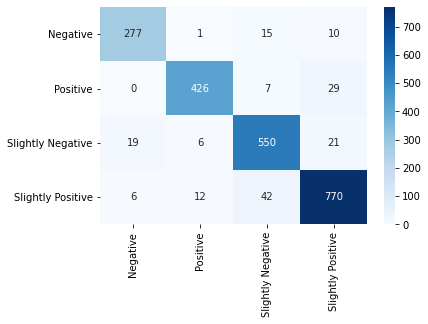

In [201]:
import seaborn as sns
sns.heatmap(cm_df, annot=True,cmap='Blues',fmt='g')

This confusion matrix looks so much better than our baseline logistic regression one from the previous notebook

## Conclusion

With an improvement of nearly 25% in our accuracy and much higher f1 scores all around it's safe to say the stacked model using Gradient Boosted Classification and Dense/Sparse Naive Bayes Probability is the best one

In the next, and final notebook, we'll be use our model to make a prediction based on new yelp data, and we'll be deploying it so that it can be used on a web app. 

This last step has taken a while, and we've come such a long way from where we started, but it's good to finally have an accurate model that we can use to have a better rating system on Yelp!

In [205]:
filename = 'yelp_model.sav'
pickle.dump(clf, open(filename, 'wb'))